# How Much Can I Earn?

The core of Ethereum's Proof of Stake consensus mechanism launched in December 2020, finally delivering the first phase of a vision set out [in 2014](https://blog.ethereum.org/2014/07/05/stake/), a full year before Ethereum's mainnet launch. In Ethereum's Proof of Stake, the blockchain is secured by *validators* who submit a stake of 32 ETH and are given the duty of coming to consensus on the state of a new blockchain called the *beacon chain*. They are incentivised to do this reliably with rewards for carrying out their duties, and penalties for failing to do this properly. There are also severe penalties (slashing) for validators who can be proven to have acted maliciously.

These  validator rewards and penalties are a little more complex than the the block rewards familiar from Proof of Work blockchains. While some excellent resources such as [beaconcha.in](https://beaconcha.in) can help validators to understand *how much* they are earning, it may not be obvious *why*. This article will try and give validators a feeling for how much they can earn, and how this may vary, even if the validator operates perfectly.

# The Ideal Case

You might have seen an "estimated APR" for running a validator, such as the graphic on the Proof of Stake [launchpad](https://launchpad.ethereum.org/) and wonder whether those numbers are realistic — where do they come from anyway? In fact, all the APR estimations currently available rest on a series of assumptions (often unstated), and in some cases are not actually using the mainnet version of the beacon chain spec. So to start off, let's look at what validators would earn if they — and all other validators — participated perfectly. I'll be using Ben Edginton's invaluable [annotated spec](https://benjaminion.xyz/eth2-annotated-spec/phase0/beacon-chain) to do this.

Ethereum validators receive rewards for participating every *epoch* (6.4 minutes). The rewards that they receive are a multiple of something called the `base_reward`. One `base_reward` is paid to each validator for accurately voting on (or, in the jargon, *attesting to*) current values of each of 3 aspects of the beacon chain. I'll refer to these three rewards colllectively as the *accuracy rewards*. They get a fourth reward, the *inclusion reward*, if their vote (*attestation*) is included promptly into a beacon chain block. So the maximum reward a validator can receive each epoch is `4 * base_reward`. To work out how much validators can earn, then, we need to know how `base_reward` is determined.

For the beacon chain, we want to incentivise a good level participation, without paying out more issuance than necessary. If there aren't many validators, the protocol needs to offer a high return, to encourage more validators to join. However if there is already a large number of validators, the protocol and pay less, and save on issuance. The function which does this for the beacon chain is an inverse square root — that is, the level of the reward is divided by the square root of currently validating Ether (the reasoning for choosing an inverse square root relationship is explained in Vitalik Buterin's [design rationale](https://notes.ethereum.org/@vbuterin/rkhCgQteN?type=view#Base-rewards) document). Again, from the annotated spec we have:

`base_reward = effective_balance * BASE_REWARD_FACTOR // integer_squareroot(total_balance) // BASE_REWARDS_PER_EPOCH`

Which calculates the `base_reward` for each validator, measured in gwei (=10<sup>-9</sup> ETH), where the terms have the following meanings:

| Term | Meaning |
| :- | :- |
| `effective_balance` | An integer number of ETH according to each validator's balance (measured in Gwei). It has a maximum value of 32 &times; 10<sup>9</sup>. |
| `BASE_REWARD_FACTOR` | A constant value of 64 in the eth2 spec, it is the factor used to tune the overall issuance of ETH — some of the rationale for this value was given in the [pull request](https://github.com/ethereum/eth2.0-specs/pull/971) in which it was set. |
| `total_balance` | The sum of the `effective_balance`s of all active validators |
| `BASE_REWARDS_PER_EPOCH` | This is a constant value of 4, corresponding to the 4 `base_reward`s which can be earned by each validator, each epoch. |

For our ideal reward case, this all simplifies down, since *all* validators have an effective balance of 32 ETH. So the ideal base reward, when all validators participate perfectly is:

`base_reward = 512e9 * // integer_squareroot(n * 32e9)`

(NB again this is measured in gwei, but we can just divde by 10<sup>9</sup> to convert to ETH)

And then to turn this into an annual ideal reward, we simply multiply by the number epochs in a year, which is the number of seconds in a year (31556952) divided by the number of seconds in in an epoch (384) to give approximately 82180 epochs per year. The ideal annual per-validator reward is plotted below, as a function of total staked Ether.

In [40]:
# define annualised base reward
import math

def annualised_base_reward(n):
    return 81280 * 512 / math.sqrt(n * 32e9)

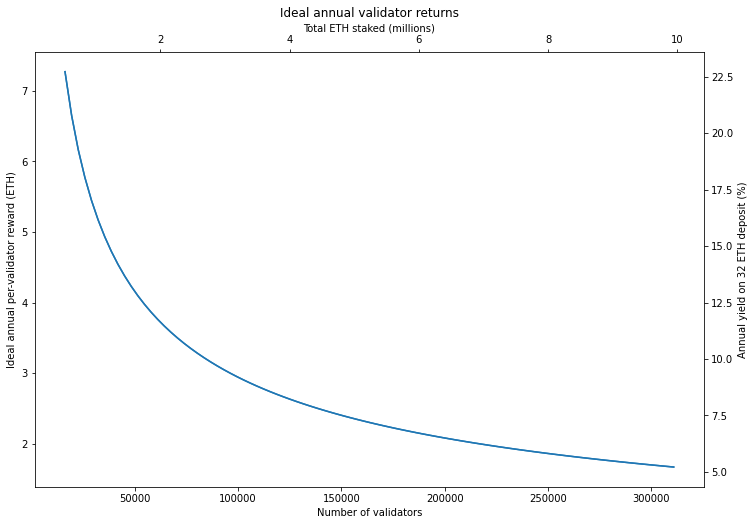

In [41]:
# plot ideal ETH staking return

import matplotlib.pyplot as plt

n_validators = [n for n in range(524288//32,int(10e6)//32,3200)]
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]

fig = plt.figure(figsize=(12, 8))

ax1=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax1.plot(n_validators, ideal_reward)
ax2.plot([n * 32e-6 for n in n_validators], [100 * r / 32 for r in ideal_reward])

ax1.set_xlabel('Number of validators')
ax1.set_ylabel('Ideal annual per-validator reward (ETH)')

ax2.set_title('Ideal annual validator returns')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel('Total ETH staked (millions)')
ax2.set_ylabel('Annual yield on 32 ETH deposit (%)');

A few values from this graph are tabulated below for reference

In [42]:
# tabulate a few values for validator return

import pandas as pd

n_validators = [524288 // 32, 50000, 100000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators]
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]
annual_yield = [100 * r / 32 for r in ideal_reward]
data = {
    'n_validators': n_validators,
    'total_staked (ETH)': staked,
    'annual_reward (ETH)': ideal_reward,
    'annual_yield (%)': annual_yield
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('n_validators')

,total_staked (ETH),annual_reward (ETH),annual_yield (%)
n_validators,,,
16384,524288,7.27,22.72
50000,1600000,4.16,13.00
100000,3200000,2.94,9.20
150000,4800000,2.40,7.51
200000,6400000,2.08,6.50
250000,8000000,1.86,5.82
300000,9600000,1.70,5.31
312500,10000000,1.66,5.20


# Block Rewards
The figure and table above give us a highly idealised version of what validators would earn if all validators participated perfectly, and all rewards were distributed evenly. However, there is an important component missing from this picture, which is the beacon chain block reward.

Although the level of rewards allocated in the beacon chain are completely dependent on the process of attestation described above, the attestations themselves have to be packaged into blocks to form the beacon chain. At every slot (a slot is 12 seconds), one validator, chosen at random, is responsible for producing a block. Rather than a fixed block subsidy (as in eth1), block producers are rewarded with a proportion of all the inclusion rewards in the block. This makes sense, as it means that the block producer has an incentive to include all the valid attestations they can gather for the block.

In the beacon chain spec, the proportion of the inclusion rewards given to the block producer is determined by a constant called `PROPOSER_REWARD_QUOTIENT`, which has a value of 8. That is ⅛ of the inclusion rewards go to the block producer, and ⅞ go to the validators whose attestations are included in the block.

Since every validator has an equal chance of being selected to produce a block, in the long run the rewards should even out, matching the graph above. But over any finite timescale, there will be variability in rewards, since some validators will be lucky and propose a greater than average number of blocks, and some unlucky, proposing fewer.

To work out how significant is the element of luck in block proposal frequency we can apply some basic statistics. Every validator has an equal chance of being selected to propose each slot, and there are `31556952 / 12 = 2629746` slots per year. If there are 100,000 validators then the chance of being selected to propose each slot is 10<sup>-5</sup>. The number of block proposal opportunities each validator gets will be governed by the binomial distribution.

The unluckiest 1% of validators will have the opportunity to produce at most 15 blocks in a year
The median (average) validator will have the opportunity to produce 26 blocks in a year
The luckiest 1% of validators will have the opportunity to produce at least 39 blocks in a year


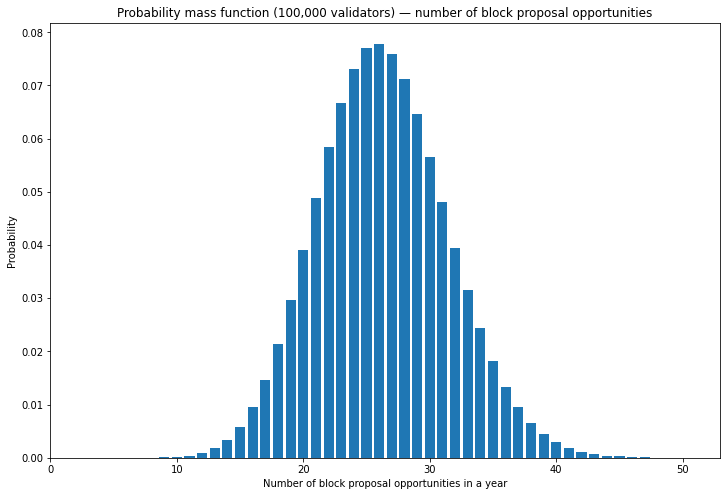

In [8]:
# plot pdf

from scipy.stats import binom

x = [el for el in range(51)]
y = binom.pmf(x, 31556952/12, 1e-5)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x, y)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_title('Probability mass function (100,000 validators) — number of block proposal opportunities')
ax.set_xlabel('Number of block proposal opportunities in a year')
ax.set_ylabel('Probability')

lmu = binom.ppf([0.01, 0.5, 0.99],31556952/12, 1e-5)

print(f"The unluckiest 1% of validators will have the opportunity to produce at most {int(lmu[0])} blocks in a year")
print(f"The median (average) validator will have the opportunity to produce {int(lmu[1])} blocks in a year")
print(f"The luckiest 1% of validators will have the opportunity to produce at least {int(lmu[2])} blocks in a year")

So we can see that there is significant variability in the number of block proposal opportunities each validator will receive, based on luck alone. The luckiest 1% of validators will propose well over twice as many blocks, in the course of a year, as the unluckiest 1%. Over a long enough time, this effect evens out. However, as the number of validators increases and the probability of proposing a block goes down, the unevenness increases.

To show this effect, I've recalculated the ideal validator returns graph, but now I'm going to calculate lines to show the luckiest and unluckiest 1% of validators, to demostrate the effect this has on validator rewards. Another way of looking at this is that 98% of validators' reward levels sit between the two lines.

With 50,000 validators:
the luckiest 1% of validators receive 1.0% greater reward than average
the unluckiest 1% of validators receive 1.0% smaller reward than average

With 100,000 validators:
the luckiest 1% of validators receive 1.5% greater reward than average
the unluckiest 1% of validators receive 1.3% smaller reward than average

With 200,000 validators:
the luckiest 1% of validators receive 2.1% greater reward than average
the unluckiest 1% of validators receive 1.7% smaller reward than average


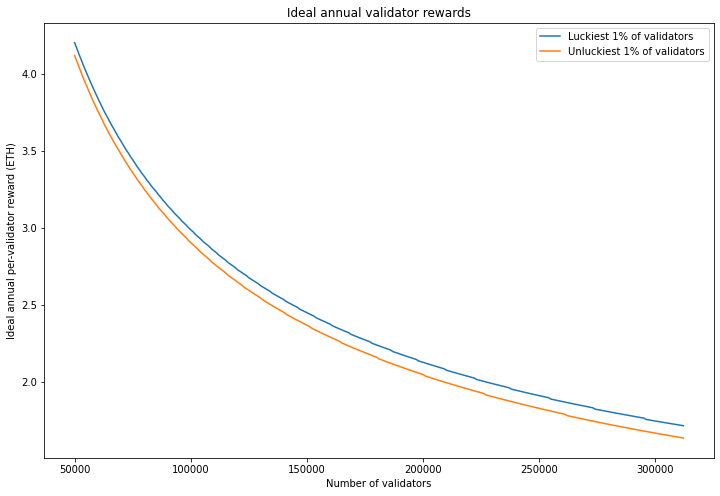

In [43]:
# plot ideal ETH staking return with interpercentile range

n_validators = [n for n in range(50000,int(10e6)//32,1000)]
full_reward = [4 * annualised_base_reward(n) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(n_validators, u_reward, label='Luckiest 1% of validators')
ax.plot(n_validators, l_reward, label='Unluckiest 1% of validators')

ax.set_xlabel('Number of validators')
ax.set_ylabel('Ideal annual per-validator reward (ETH)')
ax.set_title('Ideal annual validator rewards')
leg = ax.legend()

ratio0 = 100 * (u_reward[0] / full_reward[0] - 1)
ratio1 = 100 * (1 - l_reward[0] / full_reward[0])
print(f"With 50,000 validators:\nthe luckiest 1% of validators receive {ratio0:.1f}% greater reward than average"
     f"\nthe unluckiest 1% of validators receive {ratio1:.1f}% smaller reward than average")

ratio0 = 100 * (u_reward[50] / full_reward[50] - 1)
ratio1 = 100 * (1 - l_reward[50] / full_reward[50])
print(f"\nWith 100,000 validators:\nthe luckiest 1% of validators receive {ratio0:.1f}% greater reward than average"
     f"\nthe unluckiest 1% of validators receive {ratio1:.1f}% smaller reward than average")

ratio0 = 100 * (u_reward[150] / full_reward[150] - 1)
ratio1 = 100 * (1 - l_reward[150] / full_reward[150])
print(f"\nWith 200,000 validators:\nthe luckiest 1% of validators receive {ratio0:.1f}% greater reward than average"
     f"\nthe unluckiest 1% of validators receive {ratio1:.1f}% smaller reward than average")

As can be seen from the graph and stats calculated above, there is a potential variation in reward in the range of a few percent over the course of a year. Remember, this applies even though in our ideal case, every validator performs their duties *perfectly*. The effect gradually increases as the validator set grows, due to the reduced probability of block proposal for each validator.

While this level of variation is perhaps not worrying from the point of view of the investment risk for validators, it is worth bearing in mind as we delve into the actual performance of validators in the network. Very marginal differences in performance can easily be swallowed up — even over the course of a whole year, as modelled here — by the random variation in block proposal opportunities given to validators.

# Modelling Imperfect Participation
Our model so far has assumed that all validators carry out their duties perfectly. This allows us to set an upper bound on on the rewards available, subject to the variation in block producer opportunities explained above. To get a bit closer to modelling real-world rewards however, we need to consider the impact of a less-than-perfect  validator set. Even if *you* are running a perfect validator with zero downtime, your rewards will be impacted if the rest of the network falls short of the ideal case. The beacon chain incentives are designed such that rewards for everyone are maximised if overall network performance is optimised. This helpfully disincentivises adversarial behaviour (such as trying to take other validators offline to maximise your own rewards), but it does mean that individual validators' rewards can be reduced through no fault of their own.

There are lots of reason why validators might fail to produce attestations, or fail to propagate them to the network, or fail to produce blocks, or fail to have their blocks accepted by the network. Modelling all of these factors would be very difficult, so we'll try something simpler. We'll assume that either validators are online and operating perfectly, or they are offline and not fulfilling out their duties at all. 

## Perfect Validator on an Imperfect Network

Considering a perfect validator operating within an imperfect validator set, there are two mechanisms that will tend to reduce the rewards they receive:

1. For the accuracy rewards, the reward is scaled by the proportion of active validators who voted the same way. So if 99% of the validators are online and vote correctly, the rewards are scaled by 0.99.
2. If our pefect validator's attestation is included late — for example because the block producer in the slot after our attestation fails to produce a block because it is offline — then the inclusion reward received by the attester is cut in half for every slot it is late (i.e. it scales by ½, then ⅓, then ¼ etc.).

So it's easy to work out that if 99% of the network participates correctly in one epoch, the impact on the accuracy rewards for our perfect validator is a 1% reduction from the ideal case. The inclusion reward is a little more tricky however. Again, it comes down to luck — if the block producer who *should have* included our attestation at the next slot just happens to be part of the 1% of validators who are offline, then our inclusion reward will be cut in half. If we are exceptionally unlucky and this happens twice in a row, then our inclusion delay will be reduced by a factor of four.

Calculating the *expected* (i.e. average) inclusion reward, taking account of every possible delay is given by the sum of a geometric series (this was previously explained for modelling [by Herman Junge](https://github.com/hermanjunge/eth2-reward-simulation/blob/master/assumptions.md#attester-incentives)). If *B* is the `base_reward` and *P* is the proportion of validators who are online, we calculate the expected reward as:
$$ \begin{align}
E(P) &= \frac{7}{8}B\left(P + \frac{P(1-P)}{2} + \frac{P(1-P)^2}{3} + \ldots\right) \\ &= \frac{7}{8}BP\sum_{i=1}^{\infty}\frac{(1-P)^{i-1}}{i} \\ &= \frac{7}{8}BP\frac{\ln(P)}{P-1}
\end{align} $$

Note that the latest that an attestation can be included into the chain is a delay of 32 slots. Properly therefore, we should only sum up to 32 rather than infinity as in the above form. However if the participation rate $P$ is high (e.g. in the 99% range as in the current network), the error that results from summing to infinity rather than 32 is vanishingly small.

So now let's plot the expected rewards for a perfect validator operating within a range of different participation rate scenarios, bearing in mind that in the 4 months since the genesis of the beacon chain, the participation rate has [almost never dipped below 96%](https://beaconcha.in/charts/participation_rate).

at P = 0.99, rewards fall by 0.89%
at P = 0.98, rewards fall by 1.78%
at P = 0.97, rewards fall by 2.68%
at P = 0.96, rewards fall by 3.57%


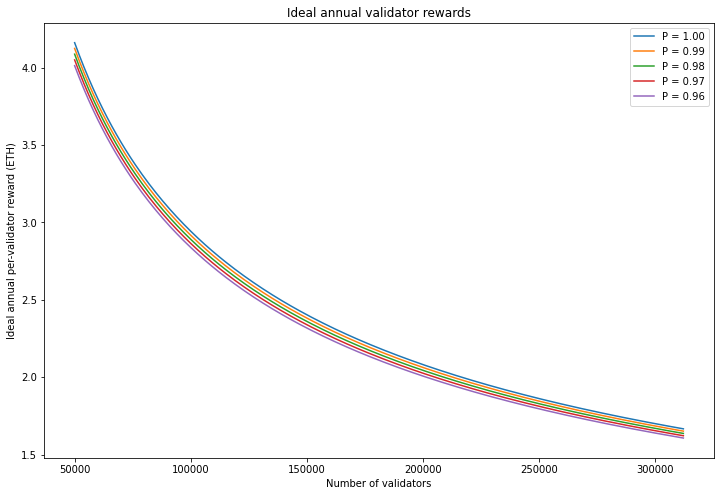

In [44]:
# plot reward for perfect validator in several participation level contexts

participation_rate = [1,0.99,0.98,0.97,0.96]

n_validators = [n for n in range(50000,int(10e6)//32,1000)]
base_reward = [annualised_base_reward(n) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

r_100000 = []
for P in participation_rate:
    accuracy_rewards = [P * 3 * r for r in base_reward]
    if P < 1:
        inclusion_reward = [(7/8) * r * P * math.log(P) / (P-1) for r in base_reward]
    else:
        inclusion_reward = [(7/8) * r for r in base_reward]
        
    block_reward = [(1/8) * r * P for r in base_reward]
    total_reward = [accuracy_rewards[i] + inclusion_reward[i] + block_reward[i]
                    for i in range(len(block_reward))]
    ax.plot(n_validators, total_reward, label=f'P = {P:.2f}')
    r_100000.append(total_reward[50])
    
ax.set_xlabel('Number of validators')
ax.set_ylabel('Ideal annual per-validator reward (ETH)')
ax.set_title('Ideal annual validator rewards')
leg = ax.legend()

print(f'at P = {participation_rate[1]:.2f}, rewards fall by {100 * (1 - r_100000[1] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[2]:.2f}, rewards fall by {100 * (1 - r_100000[2] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[3]:.2f}, rewards fall by {100 * (1 - r_100000[3] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[4]:.2f}, rewards fall by {100 * (1 - r_100000[4] / r_100000[0]):.2f}%')

As shown in the graph and figures above, rewards for our perfect validator fall slightly less than the drop in participation in the network in general.

## Imperfect Validator on a Perfect Network

If our own validator is in fact offline some of the time then we have to factor in penalties it will receive for missed attestations. The accuracy rewards each have counterpart penalties — providing incorrect attestations, or failing to provide an attestation at all, is penalised by a single `base_reward` for each part of the attestation that was incorrect. This means that *missed* attestations result in a penalty of `3 * base_reward`. To see what impact this has, imagine that you are running a validator which has some level of downtime, but that every other validator on the network behaves perfectly. We'll ignore the fact that the network participation rate is actually just below 100% due to our imperfect validator and instead model the network as being 'perfect' whilst our validator occasionally goes offline. What would the impact on our profitability be, taking into account the penalties we will accrue for going offline?

Operating as part of an otherwise perfect validator set, our validator earns an expected `4 * base_reard` when it is online, and suffers a penalty of `3 * base_reward` when it is offline. So for `base_reward` $B$ and uptime fraction $U$, the net reward $R$ is given by:
$$\begin{align}
R &= 4BU - 3B(1-U)\\
  &= B(7U - 3)
\end{align}$$
And if the net reward is zero, we have:
$$
U = \frac{3}{7} \approx 43\%
$$

Which implies as long as the validator is *online* at least 43% of the time, it will be profitable.

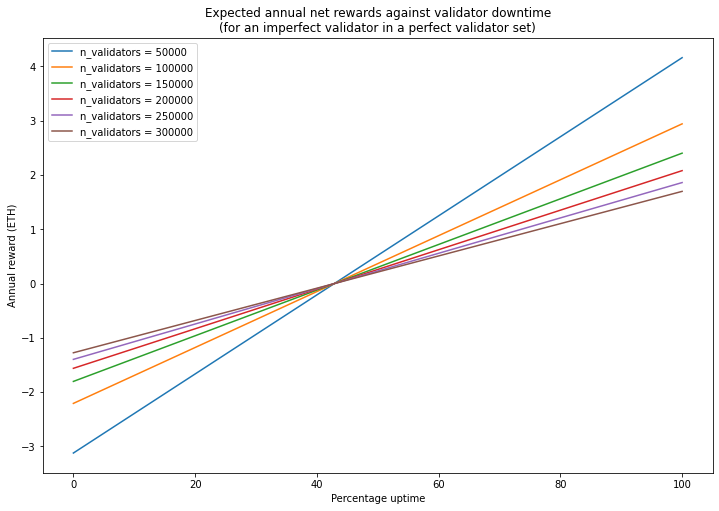

In [45]:
# plot expected reward for imperfect validator/perfect network at various validator set sizes

n_validators = [50000, 100000, 150000, 200000, 250000, 300000]
uptime = [i / 100 for i in range(101)]

fig, ax = plt.subplots(figsize=(12, 8))
for n in n_validators:
    base_reward = annualised_base_reward(n)
    net_reward = []
    for u in uptime:
        rewards = 4 * u * base_reward
        penalties = 3 * (1 - u) * base_reward
        net_reward.append(rewards - penalties)

    ax.plot(range(101), net_reward, label=f'n_validators = {n}')

ax.set_xlabel('Percentage uptime')
ax.set_ylabel('Annual reward (ETH)')
ax.set_title('Expected annual net rewards against validator downtime\n'
             '(for an imperfect validator in a perfect validator set)')
leg = ax.legend()


# Full Model
Putting this all together we have our model for an imperfect validator operating in an imperfect validator set. With a `base_reward` of $B$, a participation rate or $P$ and uptime for 'our' validator of $U$, we have:
$$
R = \underbrace{\vphantom{\frac{1}{1}}\,3\,B\,P\,U\,}_{\text{accuracy}} - \underbrace{\vphantom{\frac{1}{1}}3B\,(1-U)}_{\text{penalties}} + \underbrace{\frac{7}{8}B\,P\,U\frac{\ln(P)}{P-1}}_{\text{inclusion}} + \underbrace{\vphantom{\frac{1}{1}}\,\frac{1}{8}B\,P\,U\,}_{\text{block reward}}
$$

So, for example, if you run a validator with 99% uptime on a network of 100,000 validators with a participation rate of 99%, this model can be used to predict the following expected net reward:

In [48]:
# calculate annualised net reward for given parameters
base_reward = annualised_base_reward(100000)
participation = 0.99
uptime = 0.99
net_reward = 3 * base_reward * participation * uptime \
             - 3 * base_reward * (1 - participation)  \
             + (7/8) * base_reward * participation * uptime * math.log(participation) / (participation - 1) \
             + (1/8) * base_reward * participation * uptime

print(f'Net annual reward = {net_reward:.2f} ETH ({100 * net_reward / 32:.2f}% return on 32 ETH stake)')

Net annual reward = 2.87 ETH (8.95% return on 32 ETH stake)


# Final Notes
Congratulations for making it to the end! Hopefully this article has helped explain why and how beacon chain rewards vary — both when validators behave in an idealised fashion and when they are less than perfectly reliable.

One key takeaway from this modelling seems to be that although the available rewards vary significantly according to the number of active validators on the network, they are not dramatically affected by small amounts of down time. In fact we showed that in an idealised network, validators are profitable as long as they are online more than 43% of the time. We would not expect this minimum uptime figure to be significantly higher in the beacon chain that we observe today (which generally exhibits participation rates aroudn the 99% level). If you're considering staking your own Ether at home, this should reassure you — even major internet or power outages should not significantly affect your profitability over the course of a year.

In the next article we'll use data from the actual beacon chain to see how well this model stacks up, and see what else we can learn from this data.